In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from scipy import stats

# 1.1 Data Sanctity

In [5]:
# Read the data
df = pd.read_csv('data_la_happiness.csv')

# Check for missing values before imputation
print("\nMissing values before imputation:")
print(df.isnull().sum())

# Use sklearn simple imputer for filling
imputer = SimpleImputer(strategy='median')
columns_with_missing = ['meanHSize', 'percent_bachelorPlus']    # only these two columns have missing values
df[columns_with_missing] = imputer.fit_transform(df[columns_with_missing])

# Report mean and medians of key variables
numeric_cols = ['meanvalence', 'totalRace1', 'totalRace2', 'percent_bachelorPlus']
print("\nMeans:")
print(df[numeric_cols].mean())
print("\nMedians:")
print(df[numeric_cols].median())


df['percent_bachelorPlus'] = df['percent_bachelorPlus'] * 1000 # for scaling



Missing values before imputation:
TRACT                    0
meanHSize                5
percent_bachelorPlus    10
totalRace1               0
totalRace2               0
meanvalence              0
dtype: int64

Means:
meanvalence                5.828721
totalRace1               988.572038
totalRace2              1607.534597
percent_bachelorPlus      28.834171
dtype: float64

Medians:
meanvalence                5.822492
totalRace1               636.500000
totalRace2              1450.000000
percent_bachelorPlus      23.550000
dtype: float64


# 1.2 Outlier Detection

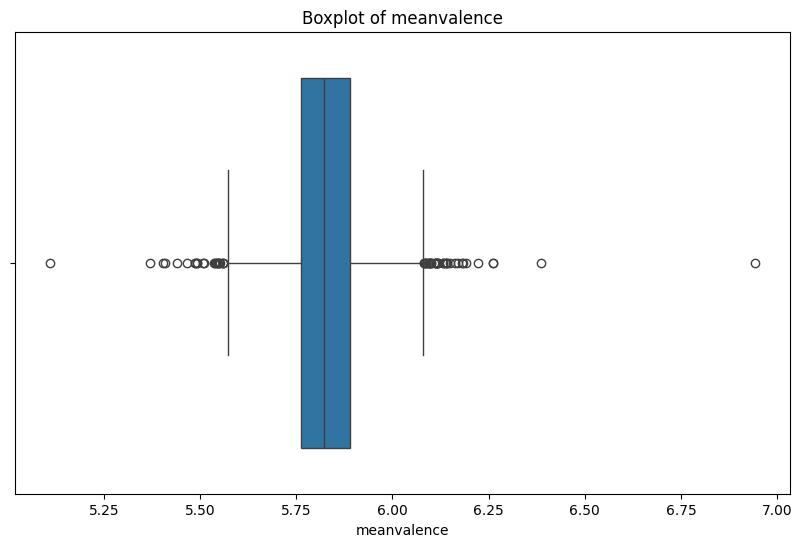


Removed 60 outliers


In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['meanvalence'])
plt.title('Boxplot of meanvalence')
plt.show()

Q1 = df['meanvalence'].quantile(0.25)
Q3 = df['meanvalence'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_clean = df[(df['meanvalence'] >= lower_bound) & (df['meanvalence'] <= upper_bound)]
print(f"\nRemoved {len(df) - len(df_clean)} outliers")


# 1.3  Variable Relationships

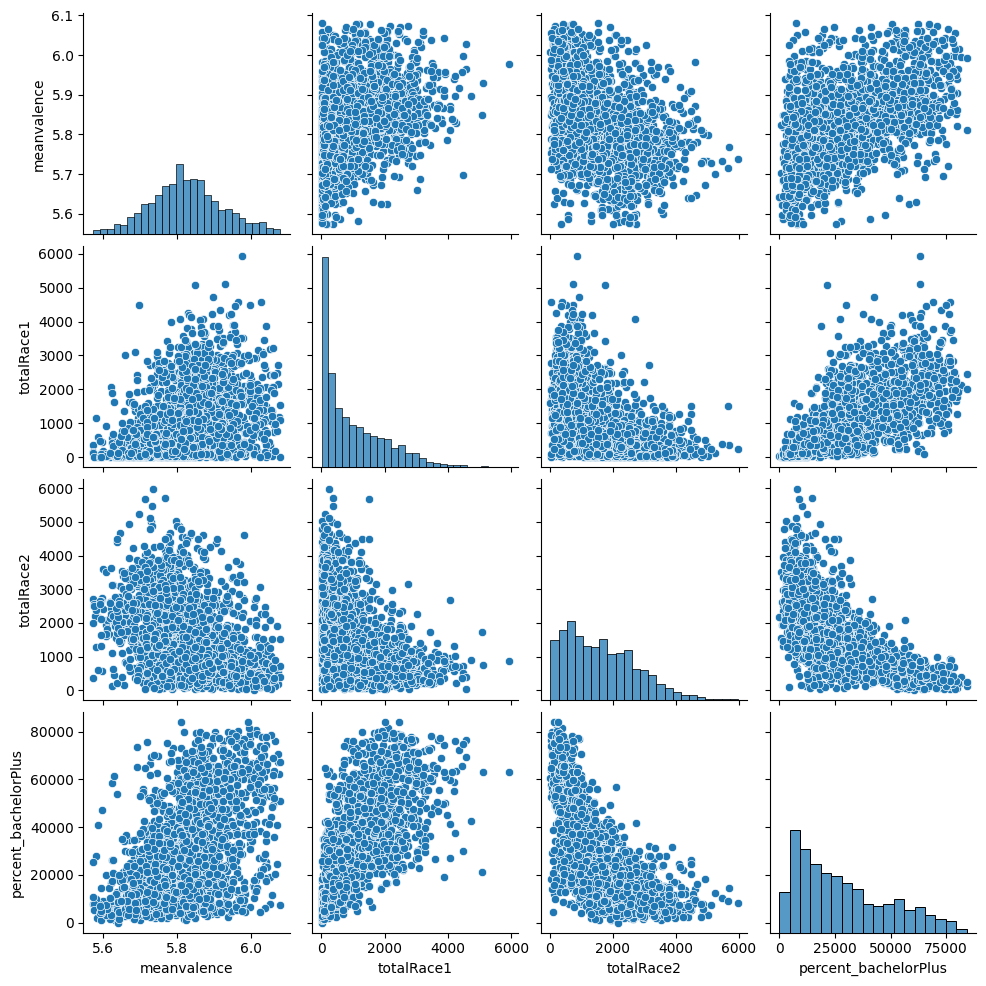


Correlations:
                      meanvalence  totalRace1  totalRace2  \
meanvalence              1.000000    0.353315   -0.372329   
totalRace1               0.353315    1.000000   -0.502882   
totalRace2              -0.372329   -0.502882    1.000000   
percent_bachelorPlus     0.480680    0.721314   -0.725850   

                      percent_bachelorPlus  
meanvalence                       0.480680  
totalRace1                        0.721314  
totalRace2                       -0.725850  
percent_bachelorPlus              1.000000  


In [9]:
sns.pairplot(df_clean[numeric_cols])
plt.show()

print("\nCorrelations:")
correlation_matrix = df_clean[numeric_cols].corr()
print(correlation_matrix)

# 1.4 Simple Models and Residual Analysis

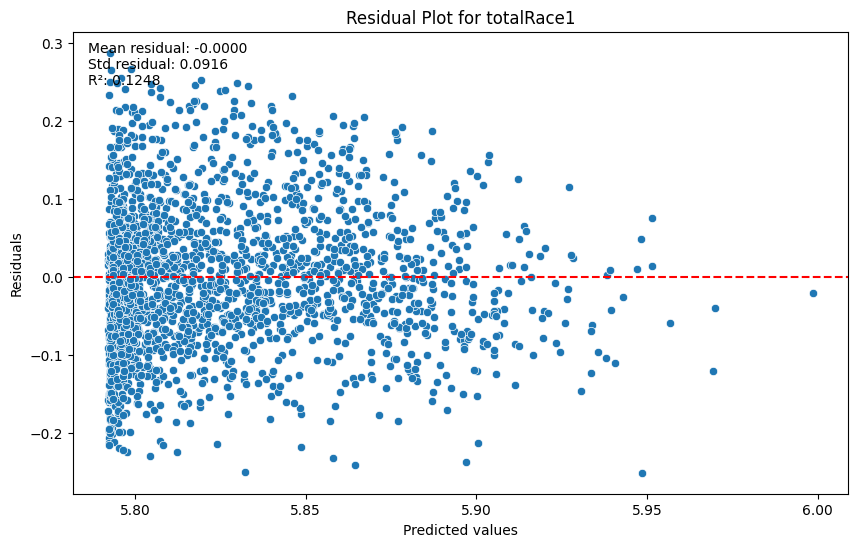


Diagnostic tests for totalRace1:
Shapiro-Wilk test for normality of residuals:
p-value: 0.0000


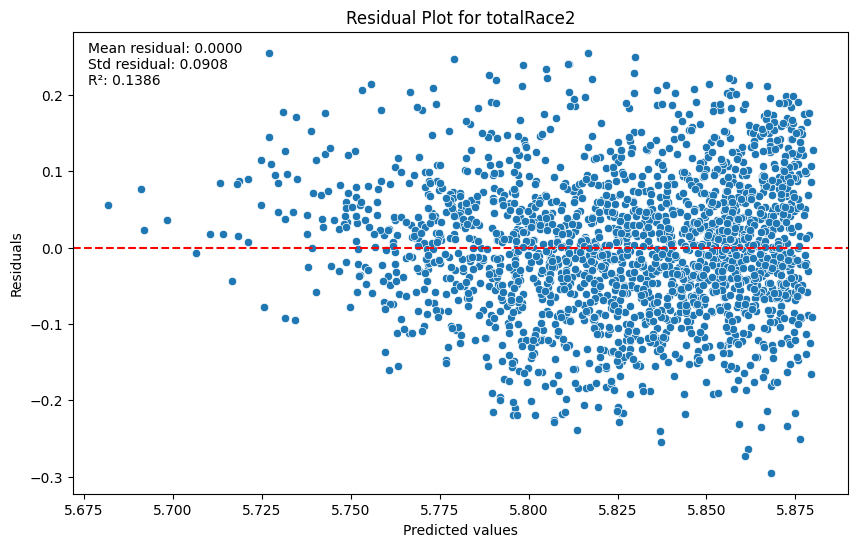


Diagnostic tests for totalRace2:
Shapiro-Wilk test for normality of residuals:
p-value: 0.0155


In [11]:
def analyze_model(X, y, feature_name):
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    
    plt.figure(figsize=(10, 6))
    residuals = y - y_pred
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot for {feature_name}')
    plt.text(0.02, 0.98, f'Mean residual: {residuals.mean():.4f}\n'f'Std residual: {residuals.std():.4f}\n'f'R²: {r2_score(y, y_pred):.4f}', transform=plt.gca().transAxes, verticalalignment='top')
    plt.show()
    print(f"\nDiagnostic tests for {feature_name}:")
    print(f"Shapiro-Wilk test for normality of residuals:")
    _, p_value = stats.shapiro(residuals)
    print(f"p-value: {p_value:.4f}")
    
    return model, y_pred

model1, pred1 = analyze_model(
    df_clean[['totalRace1']],
    df_clean['meanvalence'],
    'totalRace1'
)

model2, pred2 = analyze_model(
    df_clean[['totalRace2']],
    df_clean['meanvalence'],
    'totalRace2'
)

# 1.5 Log Transformation

/tmp/ipykernel_15592/3832295286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['log_totalRace1'] = np.log(df_clean['totalRace1'])
/tmp/ipykernel_15592/3832295286.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['log_totalRace2'] = np.log(df_clean['totalRace2'])


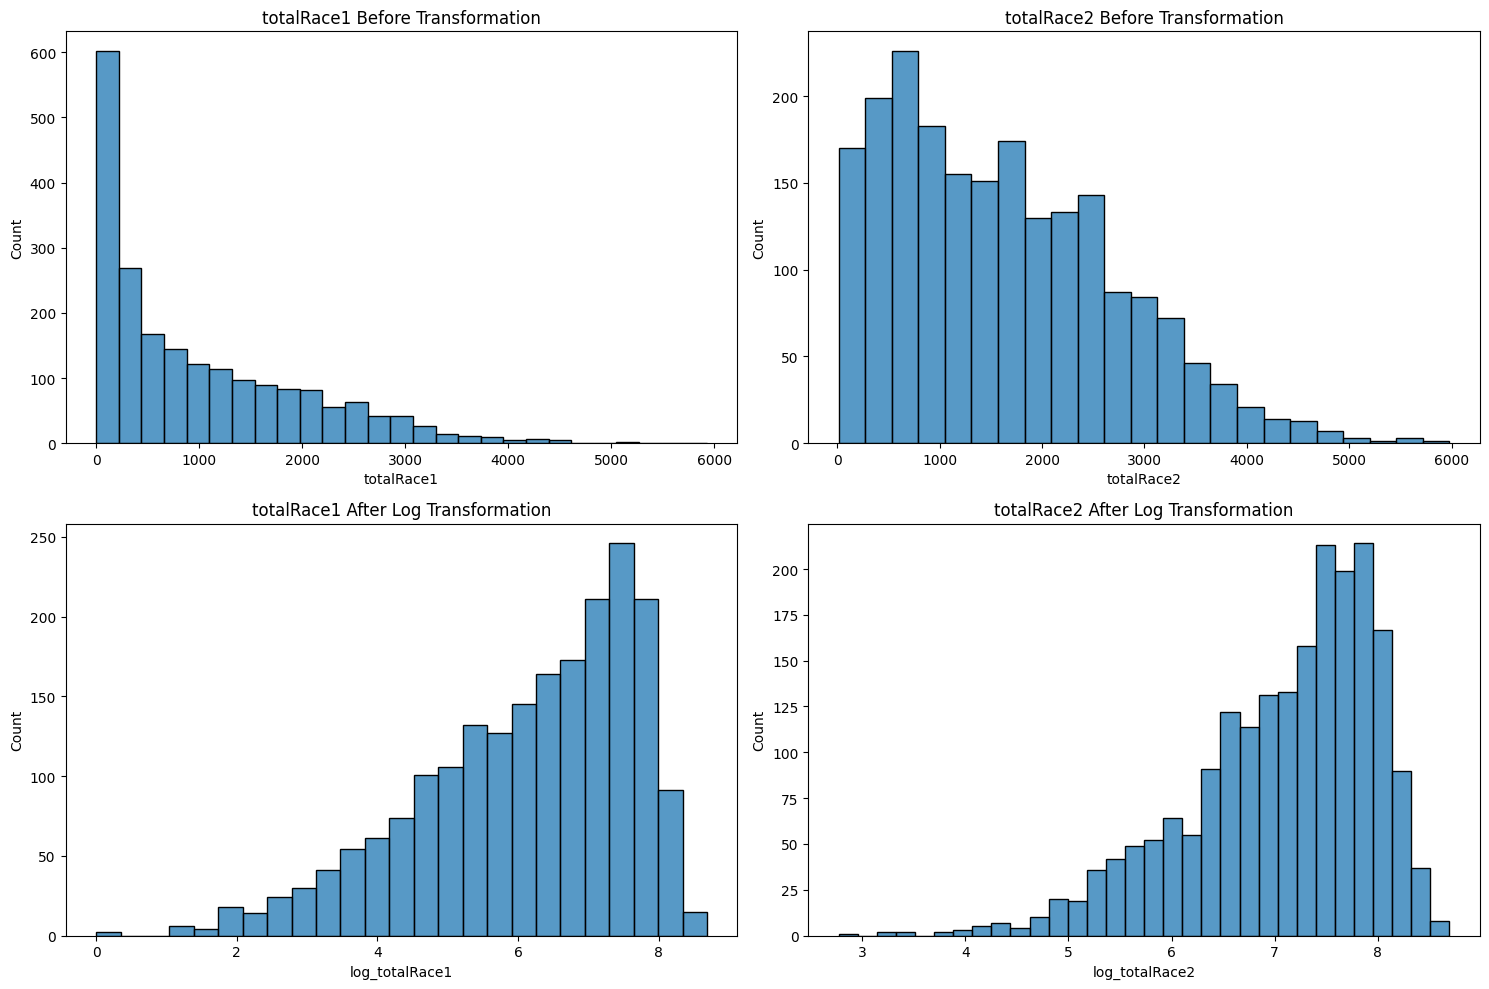

In [12]:
df_clean['log_totalRace1'] = np.log(df_clean['totalRace1'])
df_clean['log_totalRace2'] = np.log(df_clean['totalRace2'])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(df_clean['totalRace1'], ax=ax1)
ax1.set_title('totalRace1 Before Transformation')

sns.histplot(df_clean['totalRace2'], ax=ax2)
ax2.set_title('totalRace2 Before Transformation')

sns.histplot(df_clean['log_totalRace1'], ax=ax3)
ax3.set_title('totalRace1 After Log Transformation')

sns.histplot(df_clean['log_totalRace2'], ax=ax4)
ax4.set_title('totalRace2 After Log Transformation')

plt.tight_layout()
plt.show()

# 2.1 Multivariate Regression

In [13]:
X_mv = df_clean[['percent_bachelorPlus', 'log_totalRace1', 'log_totalRace2']]
y_mv = df_clean['meanvalence']

scaler = StandardScaler()
X_mv_scaled = scaler.fit_transform(X_mv)

mv_model = LinearRegression()
mv_model.fit(X_mv_scaled, y_mv)

print("\nMultivariate Model Results:")
for feature, coef in zip(X_mv.columns, mv_model.coef_):
    print(f"{feature}: {coef:.4f}")
print(f"Intercept: {mv_model.intercept_:.4f}")
print(f"R² Score: {r2_score(y_mv, mv_model.predict(X_mv_scaled)):.4f}")


Multivariate Model Results:
percent_bachelorPlus: 0.0365
log_totalRace1: 0.0082
log_totalRace2: -0.0060
Intercept: 5.8266
R² Score: 0.2349


# 2.2 Scatterplot Analysis

/tmp/ipykernel_15592/852706963.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['predicted_meanvalence'] = mv_model.predict(X_mv_scaled)


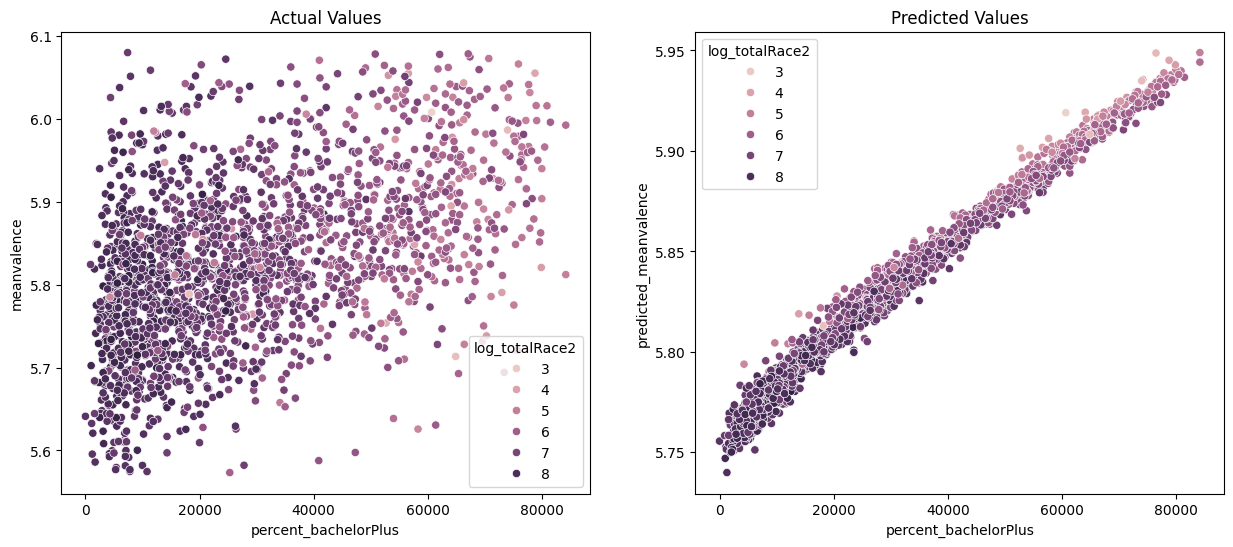

In [14]:
df_clean['predicted_meanvalence'] = mv_model.predict(X_mv_scaled)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(data=df_clean, x='percent_bachelorPlus', y='meanvalence', hue='log_totalRace2', ax=ax1)
ax1.set_title('Actual Values')
sns.scatterplot(data=df_clean, x='percent_bachelorPlus', y='predicted_meanvalence', hue='log_totalRace2', ax=ax2)
ax2.set_title('Predicted Values')

plt.show()

# 2.3 Correlation Heatmap

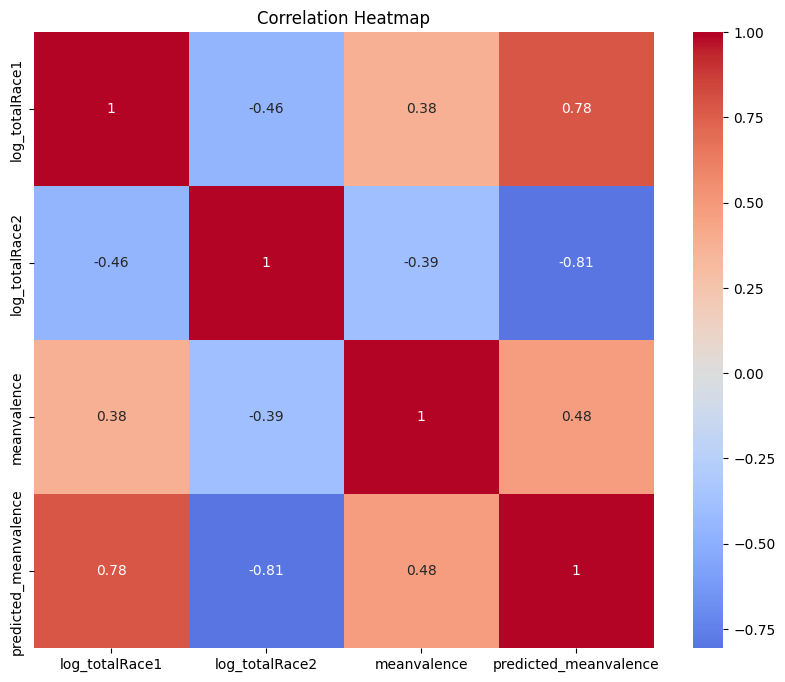

In [15]:
corr_vars = ['log_totalRace1', 'log_totalRace2', 'meanvalence', 'predicted_meanvalence']
corr_matrix = df_clean[corr_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

# 3.1 Protected Variable Analysis


Protected Model Results:
percent_bachelorPlus: 0.0420
log_totalRace1: 0.0070
Intercept: 5.8266
R² Score: 0.2335


/tmp/ipykernel_15592/1292236573.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['protected_predicted_meanvalence'] = protected_model.predict(X_protected_scaled)


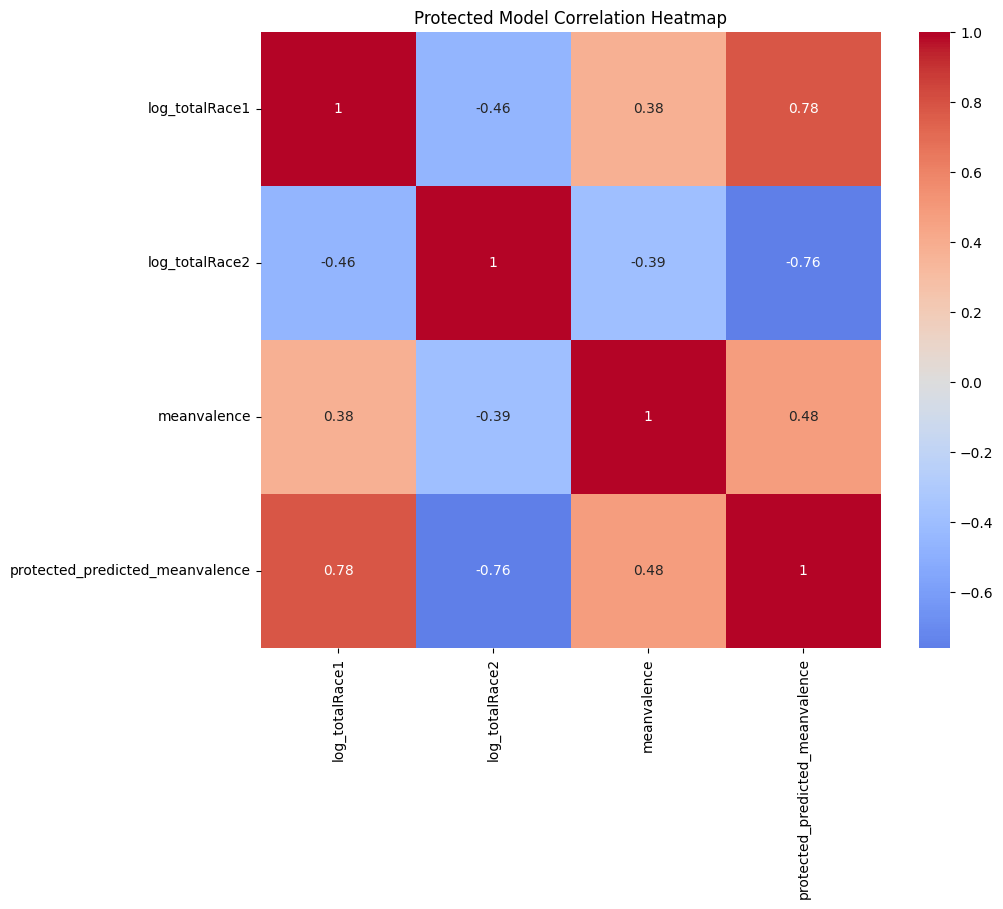

In [16]:
X_protected = df_clean[['percent_bachelorPlus', 'log_totalRace1']]
X_protected_scaled = scaler.fit_transform(X_protected)

protected_model = LinearRegression()
protected_model.fit(X_protected_scaled, y_mv)

print("\nProtected Model Results:")
for feature, coef in zip(X_protected.columns, protected_model.coef_):
    print(f"{feature}: {coef:.4f}")
print(f"Intercept: {protected_model.intercept_:.4f}")
print(f"R² Score: {r2_score(y_mv, protected_model.predict(X_protected_scaled)):.4f}")

df_clean['protected_predicted_meanvalence'] = protected_model.predict(X_protected_scaled)

protected_corr_vars = ['log_totalRace1', 'log_totalRace2', 'meanvalence', 
                      'protected_predicted_meanvalence']
protected_corr_matrix = df_clean[protected_corr_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(protected_corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Protected Model Correlation Heatmap')
plt.show()

# Discussion:

Yes, it does reduce the bias to some extent, for the correlation absolute value between log_totalRace2 and meanValence is reduced.
